In [1]:
# !pip3 install foolbox==3.0.0b1

In [2]:
import foolbox as fb
import torch
import torchvision
import tensorflow as tf
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from scipy.special import softmax

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880, got 864


In [3]:
model = torchvision.models.vgg16(pretrained=True)
model = model.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0, 1))

In [4]:
im_orig = Image.open("test_im2.jpg")
labels = torch.tensor([603])
images = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])(im_orig)

images = images.reshape(1,3,224,224)

# images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=2)
print (images.shape)
print (labels)
# fb.utils.accuracy(fmodel, images, labels)

torch.Size([1, 3, 224, 224])
tensor([603])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/transforms/transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
attack = fb.attacks.L2DeepFoolAttack()
criterion = fb.criteria.Misclassification(labels)
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=0.002)

tensor([False])
tensor([0.0819])


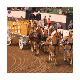

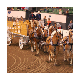

In [6]:
print (is_adv)
fb.plot.images(advs)
fb.plot.images(images)

print (fb.distances.l2(images, advs))

In [9]:
from scipy.special import softmax

im_orig = Image.open("test_im2.jpg")

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

# Remove the mean
im = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)



images = im.reshape(3,224,224)
x = Variable(images[None, :, :, :], requires_grad=True)
fs = model.forward(x)
print ("Confidence on Original Image: ", np.amax(softmax(fs.data.cpu().numpy().flatten())))
k_i = np.argmax(fs.data.cpu().numpy().flatten())
print (k_i)

# advs = advs.reshape(3,224,224)
x = Variable(advs, requires_grad=True)
fs = model.forward(x)
print ("Confidence on False Image: ", np.amax(softmax(fs.data.cpu().numpy().flatten())))
k_i = np.argmax(fs.data.cpu().numpy().flatten())
print (k_i)


original_image = images.numpy().flatten()
perturbed_image = advs.numpy().flatten()

print (original_image.shape)
print (perturbed_image.shape)

dot_product = np.dot(original_image, perturbed_image)
norm_a = np.linalg.norm(original_image)
norm_b = np.linalg.norm(perturbed_image)
cossimi = ((dot_product / (norm_a * norm_b)))
print (cossimi)


Confidence on Original Image:  0.734697
603
Confidence on False Image:  0.63544714
690
(150528,)
(150528,)
0.3917061
